# Grid Cell Phase Coding 

"Phases are in radians, coordinates are in [m] and time base is [ms]. The first data point in XYspkT corresponds with the first spike, which also corresponds with the first phase value"

After changing parameters in the second cell, from the top menu click 'Cell' -> 'Run All' then scroll through

(TODO: add firing map (#spikes/time), variance as lightness in meanphasemap (pi), variance weighting, amount of spikes vs. correlation, temporal separation of spikes vs. correlation, radial distribution of prediction variance, population vector prediction,
low variance phase map?)

(note whether coordinates in numpy [-y,x] or Cartesian [x,y])

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import pycircstat
from scipy import ndimage

%matplotlib inline
np.set_printoptions(suppress=True)
%config InLineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [20, 15]


In [2]:
XYspkT = np.loadtxt('datasets/1/XYspkT.csv',delimiter=',')

#Aligns positions to [0,0] in the bottom-left corner
XYspkT[:,1] -= XYspkT[:,1].min()
XYspkT[:,0] -= XYspkT[:,0].min()
scaled_XY = XYspkT/2

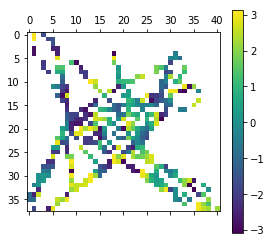

In [3]:
raw = np.loadtxt('datasets/1/MeanPhaseMap.csv',delimiter=',')

#Flipping to align + stripping erraneous values
MeanPhaseMap = np.flip(raw,axis=0)
MeanPhaseMap[0]='NaN'
MeanPhaseMap[:,-1]='NaN'
MeanPhaseMap = MeanPhaseMap[1:-1,:-2]
arena_size = MeanPhaseMap.shape

plt.matshow(MeanPhaseMap)

#To-do: reflect radians in bar
plt.colorbar()

/home/daniel/anaconda3/lib/python3.7/site-packages/pycircstat/descriptive.py:340: RuntimeWarning: invalid value encountered in cdouble_scalars
  np.sum(w, axis=axis))


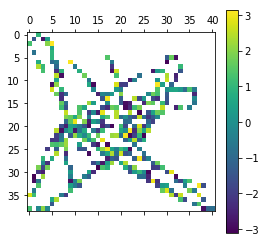

In [4]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

def mean_phase_map(arr,bin_size):
    mpm_dict = {}
    for ybin in range(0,int(arr[:,1].max()+1),bin_size):
        mpm_dict[ybin] = {}
        for xbin in range(0,int(arr[:,0].max()+1),bin_size):
            phases = []
            mpm_dict[ybin][xbin] = []
            for spike in arr:
                if (xbin <= spike[0] <= xbin+bin_size) and (ybin <= spike[1] <= ybin+bin_size):
                    phases.append(spike[2])      
            mpm_dict[ybin][xbin] = pycircstat.mean(np.asarray(phases))
            #mpm_dict[ybin][xbin] = np.nanmean(np.asarray(phases))

#             x = []
#             y = []
#             for i in phases:
#                 xi,yi= pol2cart(1, i)
#                 x.append(xi)
#                 y.append(yi)
#             x = np.mean(x)
#             y = np.mean(y)
#             a = cart2pol(x,y)
#             mpm_dict[ybin][xbin] = a[1]

    return mpm_dict

phase = np.loadtxt('datasets/1/Phase.csv',delimiter=',')
scaled_phase = phase-3.14

mpm_arr = np.column_stack((XYspkT,phase))
mpm_dict = mean_phase_map(mpm_arr,2)

#Rotate the dataframe 90 CCW
mpm = pd.DataFrame.from_dict(mpm_dict).T
phase_df = mpm.reindex(index=mpm.index[::-1])

arena_size = phase_df.shape

plt.matshow(phase_df-3.14)

#To-do: reflect radians in bar
plt.colorbar()

/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice


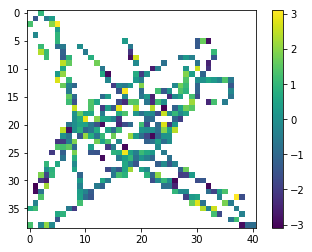

In [41]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

def mean_phase_map(arr,bin_size):
    mpm_dict = {}
    for ybin in range(0,int(arr[:,1].max()+1),bin_size):
        mpm_dict[ybin] = {}
        for xbin in range(0,int(arr[:,0].max()+1),bin_size):
            phases = []
            mpm_dict[ybin][xbin] = []
            for spike in arr:
                if (xbin <= spike[0] <= xbin+bin_size) and (ybin <= spike[1] <= ybin+bin_size):
                    phases.append(spike[2])      
            #mpm_dict[ybin][xbin] = pycircstat.mean(np.asarray(phases))
            mpm_dict[ybin][xbin] = np.nanmean(np.asarray(phases))

#             x = []
#             y = []
#             for i in phases:
#                 xi,yi= pol2cart(1, i)
#                 x.append(xi)
#                 y.append(yi)
#             x = np.mean(x)
#             y = np.mean(y)
#             a = cart2pol(x,y)
#             mpm_dict[ybin][xbin] = a[1]

    return mpm_dict

phase = np.loadtxt('datasets/1/Phase.csv',delimiter=',')
scaled_phase = phase-3.14

mpm_arr = np.column_stack((XYspkT,scaled_phase))
mpm_dict = mean_phase_map(mpm_arr,2)

#Rotate the dataframe 90 CCW
mpm = pd.DataFrame.from_dict(mpm_dict).T
phase_df = mpm.reindex(index=mpm.index[::-1])

arena_size = phase_df.shape
plt.imshow(phase_df)

#To-do: reflect radians in bar
plt.colorbar()

In [45]:
np_df = np.nan_to_num(phase_df.as_matrix())

/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


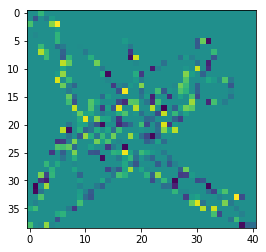

In [50]:
plt.imshow(ndimage.filters.gaussian_filter(np_df, sigma=0.2))

/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


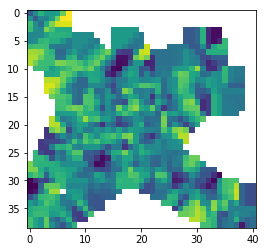

In [57]:
U = phase_df.as_matrix()
V=U.copy()
V[U!=U]=0
VV=ndimage.gaussian_filter(V,sigma=0.5)

W=0*U.copy()+1
W[U!=U]=0
WW=ndimage.gaussian_filter(W,sigma=0.5)
plt.imshow(VV/WW)

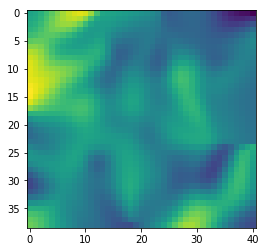

In [54]:
plt.imshow(Z)